# Pylops - seismic inversion

### Author: M.Ravasi

This notebook will focus on running post-stack inversion (for Acoustic Impedence) on GPUs using the Pylops-gpu framework

In [206]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%pylab inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import torch
import scipy as sp
import matplotlib.pyplot as plt
import pylops

from scipy.signal import filtfilt
from scipy.sparse.linalg import cg, lsqr
from pylops.utils import dottest
from pylops.utils.wavelets import ricker
from pylops import Diagonal, MatrixMult, FirstDerivative
from pylops.avo.poststack import PoststackLinearModelling

from pylops_gpu.utils.backend import device
from pylops_gpu.utils import dottest as gdottest
from pylops_gpu import FirstDerivative as gFirstDerivative
from pylops_gpu.avo.poststack import PoststackLinearModelling as gPoststackLinearModelling
from pylops_gpu.optimization import cg as gcg

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


In [32]:
dev = device()
print('PyLops-gpu working on %s...' % dev)

torch.cuda.empty_cache()

PyLops-gpu working on cpu...


## Post-stack inversion - 1D

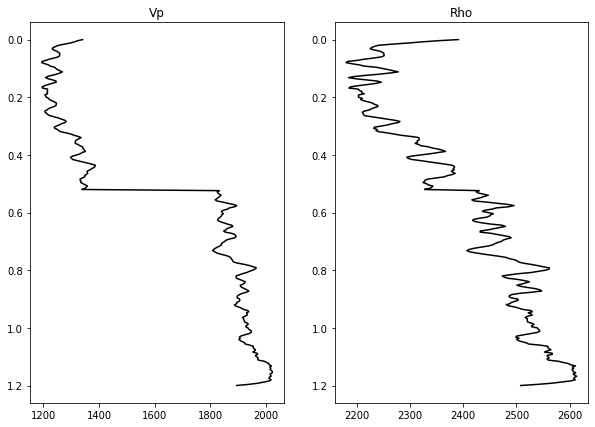

In [178]:
np.random.seed(0)

nt0 = 301
dt0 = 0.004

t0  = np.arange(nt0)*dt0
vp  = 1200 + np.arange(nt0) + filtfilt(np.ones(5)/5.,1,np.random.normal(0, 80, nt0))
rho = 1000 + vp             + filtfilt(np.ones(5)/5.,1,np.random.normal(0, 30, nt0))
vp[131:]+=500
rho[131:]+=100

# edges (for the moment)
#vp[:4]=vp[4]
#vp[-5:]=vp[-5]
#rho[:4]=rho[4]
#rho[-5:]=rho[-5]

m1d = np.log(vp*rho).flatten()
m1d = torch.from_numpy(m1d.astype(np.float32)).to(dev)

fig, axs = plt.subplots (1, 2, figsize=(10, 7))
axs[0].plot(vp,  t0, 'k')
axs[0].set_title('Vp')
axs[0].invert_yaxis()
axs[1].plot(rho, t0, 'k')
axs[1].set_title('Rho')
axs[1].invert_yaxis()

In [179]:
ntwav = 41
wav = ricker(t0[:ntwav//2+1], 15)[0]

In [184]:
# lop
PPop = gPoststackLinearModelling(torch.from_numpy(wav.astype(np.float32)), nt0=nt0, 
                                device=dev)
gdottest(PPop, nt0, nt0, verb=True, tol=1e-4)

# dense
PPop_dense = gPoststackLinearModelling(wav.astype(np.float32), nt0=nt0, explicit=True, 
                                      device=dev)
gdottest(PPop, nt0, nt0, verb=True, tol=1e-4)

# pylops
PPop_pylops = PoststackLinearModelling(wav.astype(np.float32), nt0=nt0)
dottest(PPop_pylops, nt0, nt0, verb=True, tol=1e-4)

# pylops
PPop_dense_pylops = PoststackLinearModelling(wav.astype(np.float32), nt0=nt0, explicit=True)
dottest(PPop_dense_pylops, nt0, nt0, verb=True, tol=1e-4)

# data
d = PPop * m1d
d_dense = PPop_dense * m1d
d_pylops = PPop_pylops * m1d.cpu().numpy()
d_dense_pylops = PPop_dense_pylops * m1d.cpu().numpy()

Dot test passed, v^T(Opu)=8.324730 - u^T(Op^Tv)=8.324736
Dot test passed, v^T(Opu)=-5.421285 - u^T(Op^Tv)=-5.421285
Dot test passed, v^T(Opu)=10.888320 - u^T(Op^Tv)=10.888320
Dot test passed, v^T(Opu)=-16.093954 - u^T(Op^Tv)=-16.093954


In [205]:
nsmooth = 100
m1dback = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, m1d)
m1dback = torch.from_numpy(m1dback.astype(np.float32)).to(dev)

# solve lop
d0 = PPop * m1dback
dr = d - d0
minv = gcg(PPop.H * PPop, PPop.H * dr, niter=10)[0]
minv = m1dback + minv

# solve pylops lop
d0_pylops = PPop_pylops * m1dback.cpu().numpy()
dr_pylops = d.cpu().numpy() - d0.cpu().numpy()
minv_pylops = lsqr(PPop_pylops.H * PPop_pylops, PPop_pylops.H * dr, iter_max=10)[0]
minv_pylops = m1dback.cpu().numpy() + minv_pylops

# solve dense
d0_dense = PPop*m1dback
dr_dense = d_dense - d0_dense
minv_dense = torch.solve(dr_dense.reshape(nt0, 1) , 
                         PPop_dense.A.reshape(nt0, nt0) + 1e-4*torch.eye(nt0, dtype=torch.float32)).solution.flatten()
minv_dense = m1dback + minv_dense

# solve dense pylops
d0_pylops_dense = PPop_dense_pylops*m1dback.cpu().numpy()
dr_pylops_dense = d_dense_pylops - d0_pylops_dense
#minv_pylops_dense = lstsq(PPop_dense_pylops.A, dr_pylops_dense, rcond=1e-5)[0]
minv_pylops_dense = lstsq(PPop_dense.A.cpu().numpy(), dr_dense.cpu().numpy(), rcond=1e-5)[0]
minv_pylops_dense = m1dback.cpu().numpy() + minv_pylops_dense

fig, axs = plt.subplots(1, 2, figsize=(10, 12))
axs[0].plot(d.cpu().numpy(), t0, 'k', lw=4, label='Lop')
axs[0].plot(d_dense.cpu().numpy(), t0,'--r', lw=2, label='Dense')
axs[0].plot(d_pylops, t0,'-.g', lw=2, label='PyLops')
axs[0].set_title('Data')
axs[0].invert_yaxis()
axs[0].axis('tight')
axs[0].legend()
axs[1].plot(m1d.cpu().numpy(), t0, 'k', lw=4, label='True')
axs[1].plot(m1dback.cpu().numpy(), t0, '--r', lw=4, label='Back')
axs[1].plot(minv.cpu().numpy(), t0, '--b', lw=2, label='Inv Lop')
axs[1].plot(minv_dense.cpu().numpy(), t0, '--g', lw=2, label='Inv Dense')
axs[1].plot(minv_pylops, t0, '--y', lw=2, label='Inv PyLops')
axs[1].plot(minv_pylops_dense, t0, '--m', lw=2, label='Inv PyLops Dense')
axs[1].set_title('Model')
axs[1].invert_yaxis()
axs[1].axis('tight')
axs[1].legend();

TypeError: zeros_like() received an invalid combination of arguments - got (numpy.ndarray), but expected one of:
 * (Tensor input, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (Tensor input, bool requires_grad)


In [ ]:
%timeit -r 3 -n 10